In [1]:
!gdown https://drive.google.com/uc?id=1o5lDC7aCsgOTnjkb_y_cKmxoVIuuQtz7
!unzip -qq Stanford_Online_Products

Downloading...
From: https://drive.google.com/uc?id=1o5lDC7aCsgOTnjkb_y_cKmxoVIuuQtz7
To: /content/Stanford_Online_Products.zip
100% 3.08G/3.08G [00:42<00:00, 73.3MB/s]


In [2]:
from IPython.display import clear_output

In [3]:
# !pip install -q -U tensorflow-addons
!pip install -q -U albumentations
!pip install pytorch-lightning

!pip uninstall opencv_python_headless
!pip install opencv-python-headless==4.1.2.30
clear_output()

In [4]:
from glob import glob
import numpy as np
from tqdm.notebook import tqdm
import os
import cv2
import matplotlib.pyplot as plt
import albumentations as A

from torchvision import models
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch

## Data

In [5]:
# save folders names to file
!find ./Stanford_Online_Products/ -type d > classes.txt

In [6]:
with open("classes.txt", "r") as f:
  classes = f.readlines()
classes = [i.strip().split("/")[-1] for i in classes][1:]
print(classes)

['toaster_final', 'lamp_final', 'mug_final', 'cabinet_final', 'coffee_maker_final', 'bicycle_final', 'stapler_final', 'kettle_final', 'sofa_final', 'chair_final', 'fan_final', 'table_final']


In [7]:
class Dataset(Dataset):
  def __init__(self, files_list_full, files_list, test=False):
    self.files_list_full = files_list_full
    self.files_list = files_list
    self.test = test
    self.transforms = self.init_transforms()

  def __getitem__(self, idx):
    # load example
    example_name = self.files_list[idx]
    example = cv2.imread(example_name)
    example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)
    example = cv2.resize(example, (212, 212))
    # load positive from the same subclass
    subclass_name = example_name.split("/")[-1].split("_")[0]
    subclass_files = [i for i in self.files_list_full if subclass_name in i]
    permutation = np.random.permutation(subclass_files)
    positive_example_file = permutation[0] if permutation[0] != example_name else permutation[1]
    positive_example = cv2.imread(positive_example_file)
    positive_example = cv2.cvtColor(positive_example, cv2.COLOR_BGR2RGB)
    positive_example = cv2.resize(positive_example, (212, 212))
    # load negative from the same class
    class_name = example_name.split("/")[-2]
    permutation = np.random.permutation(self.files_list_full)
    permutation = [i for i in permutation if i.split("/")[-1].split("_")[0] != subclass_name and i.split("/")[-2] == class_name]
    negative_example_file = permutation[0] if permutation[0] != example_name else permutation[1]
    negative_example = cv2.imread(negative_example_file)
    negative_example = cv2.cvtColor(negative_example, cv2.COLOR_BGR2RGB)
    negative_example = cv2.resize(negative_example, (212, 212))

    # Transforms
    if not self.test:
      data = {"image":example, }
      aug_data = self.transforms(**data)
      example = aug_data["image"]
      data = {"image":positive_example}
      aug_data = self.transforms(**data)
      positive_example = aug_data["image"]
      data = {"image":negative_example}
      aug_data = self.transforms(**data)
      negative_example = aug_data["image"]

    example, positive_example, negative_example = example.T/255, positive_example.T/255, negative_example.T/255
    example, positive_example, negative_example = torch.FloatTensor(example), torch.FloatTensor(positive_example), torch.FloatTensor(negative_example)

    return example, positive_example, negative_example

  def __len__(self):
    return len(self.files_list)

  def get_subclass2idx(self):
    subclasses_list = set([i.split("/")[-1].split("_")[0] for i in self.files_list_full])
    subclasses_list = {j:i for i, j in enumerate(subclasses_list)}
    subclass2idx = {i:subclasses_list[i.split("/")[-1].split("_")[0]] for i in self.files_list_full}

    return subclass2idx

  def init_transforms(self):
    transforms = A.Compose([A.RandomBrightness(limit=0.1),
                                  A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
                                  A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
                                  A.RandomContrast(limit=0.2, p=0.5),
                                  A.HorizontalFlip(),
      ])
    return transforms
    

In [8]:
# files
train_files_list = []
val_files_list = []
files_list_full = []

# First 5 classes and random 500 elements
for class_name in classes[:5]:
  files_list_class = glob(os.path.join("Stanford_Online_Products", class_name, "*"))
  np.random.shuffle(files_list_class)
  subclasses = list(set([i.split("/")[-1].split("_")[0] for i in files_list_class]))
  np.random.shuffle(subclasses)
  subclasses = subclasses[:200]
  files_list_full.extend([i for i in files_list_class if i.split("/")[-1].split("_")[0] in subclasses])

np.random.shuffle(files_list_full)

# train val split
train_files_list = files_list_full[:-int(len(files_list_full)*0.2)]
val_files_list = files_list_full[-int(len(files_list_full)*0.2):]
# datasets
train_dataset = Dataset(files_list_full, train_files_list, test=True)
val_dataset = Dataset(files_list_full, val_files_list, test=False)
# dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

print(f"Train: {len(train_files_list)}, Val: {len(val_files_list)}")

Train: 4222, Val: 1055


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:967: FutureWarning: This class has been deprecated. Please use ImageCompression
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


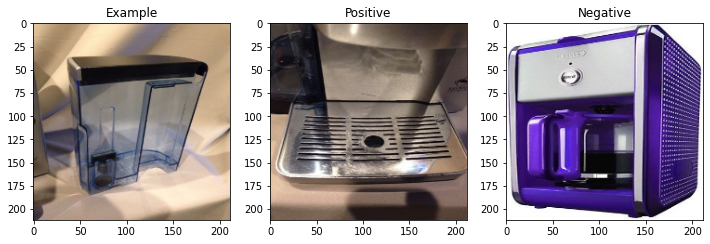

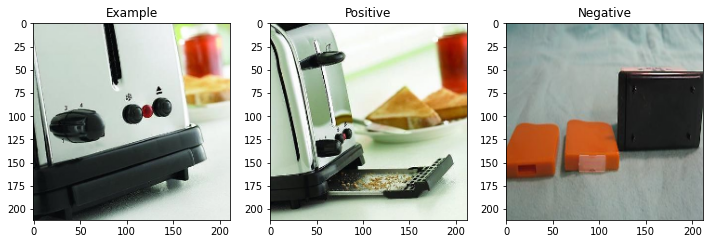

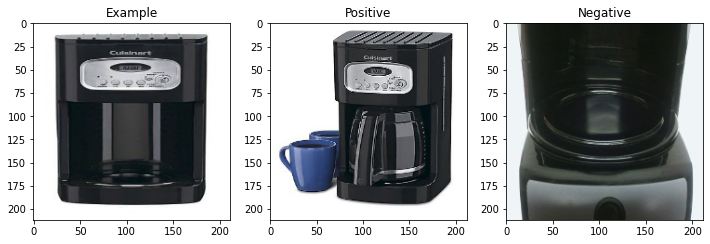

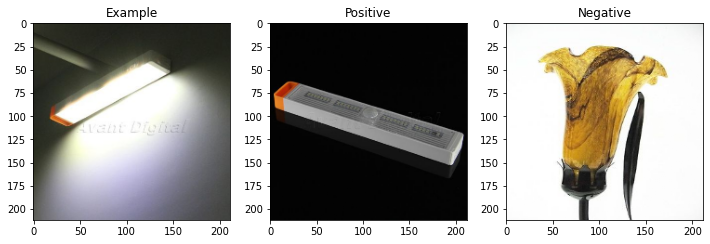

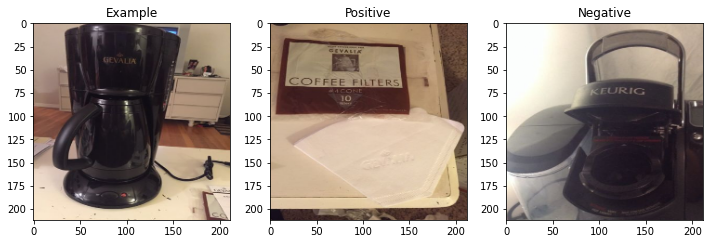

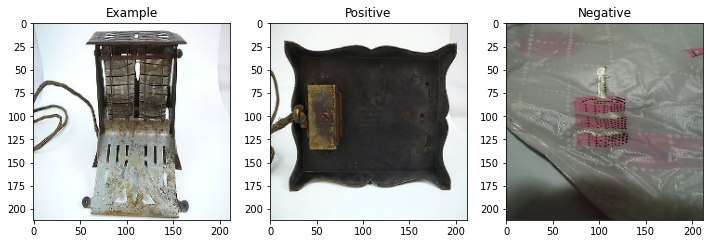

In [15]:
# display images
for i, (ex, pos, neg) in enumerate(train_dataloader):
  fig, ax = plt.subplots(1, 3, figsize=(12, 8))
  ax[0].imshow(ex[8].T)
  ax[0].set_title("Example")
  ax[1].imshow(pos[8].T)
  ax[1].set_title("Positive")
  ax[2].imshow(neg[8].T)
  ax[2].set_title("Negative")
  plt.show()

  if i == 5:
    break

## Model

In [16]:
class PretrainedModel(pl.LightningModule):
    """
    Pretrained ResNet34, emb size = 300
    """
    def __init__(self):
        super().__init__()
        self.train_accuracy_log, self.train_loss_log = [], []
        self.val_accuracy_log,self.val_loss_log = [], []
        
        self.classifier = models.resnet34(pretrained=True)
        num_ftrs = self.classifier.fc.in_features
        self.classifier.fc = torch.nn.Linear(num_ftrs, 300)        
    
    def forward(self, example, positive, negative):
        example = self.classifier(example)
        positive = self.classifier(positive)
        negative = self.classifier(negative)

        return example, positive, negative

    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-6)
        sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        #learning rate scheduler
        return {"optimizer":optimizer,
                "lr_scheduler" : {"scheduler" : sch, "monitor" : "val_loss"}
               }
    
    def training_step(self, batch, batch_idx):
        example, positive, negative = batch
        example, positive, negative = self(example, positive, negative)
        loss = torch.nn.TripletMarginLoss()(example, positive, negative)
        accuracy = self.top1_accuracy(example, positive, negative)
        # METRIC
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", accuracy, prog_bar=True)
        return {"loss": loss, "accuracy":accuracy}

    def validation_step(self, batch, batch_idx):
        example, positive, negative = batch
        example, positive, negative = self(example, positive, negative)
        loss = torch.nn.TripletMarginLoss()(example, positive, negative)
        accuracy = self.top1_accuracy(example, positive, negative)
        self.log('val_loss', loss, prog_bar=True)
        self.log("val_accuracy", accuracy, prog_bar=True)
        return {"loss": loss, "accuracy":accuracy}
        
    def training_epoch_end(self, outs):
        # log epoch metric
        self.train_loss_log.append(np.mean([i["loss"].item() for i in outs]))
        self.train_accuracy_log.append(np.mean([i["accuracy"] for i in outs]))

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.val_loss_log.append(np.mean([i["loss"].item() for i in outs]))
        self.val_accuracy_log.append(np.mean([i["accuracy"] for i in outs]))


    def top1_accuracy(self, ex, pos, neg):
      """
      If dist(ex, pos) < (ex, top1(neg)) -> Accuracy += 1
      """
      pos_dist = torch.cdist(ex, pos)
      neg_dist = torch.cdist(ex, neg)
      pos_pred_dist = [pos_dist[i, i].item() for i in range(len(pos_dist))]
      neg_pred_dist = [torch.topk(i, 1, largest=False).values.item() for i in neg_dist]
      accuracy = sum([pos_pred_dist[i] < neg_pred_dist[i] for i in range(len(pos_pred_dist))]) / len(pos_pred_dist)
      
      return accuracy

In [17]:
%%time
pretrained_model = PretrainedModel()
checkpoint = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode = "min")

trainer = pl.Trainer(gpus=1, max_epochs=15, callbacks=[checkpoint], log_every_n_steps=1)
trainer.fit(pretrained_model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params
--------------------------------------
0 | classifier | ResNet | 21.4 M
--------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.754    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:658: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 58min 54s, sys: 9min 45s, total: 1h 8min 39s
Wall time: 1h 7min 43s


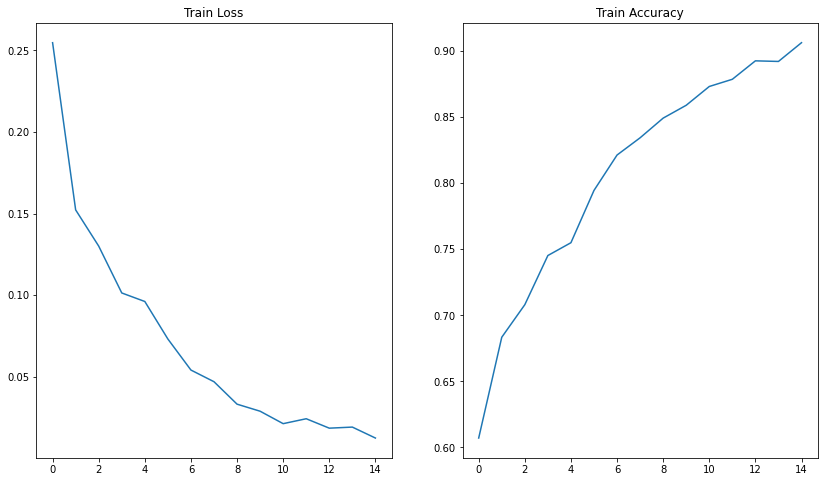

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].plot(pretrained_model.train_loss_log)
ax[0].set_title("Train Loss")
ax[1].plot(pretrained_model.train_accuracy_log)
ax[1].set_title("Train Accuracy")
plt.show()

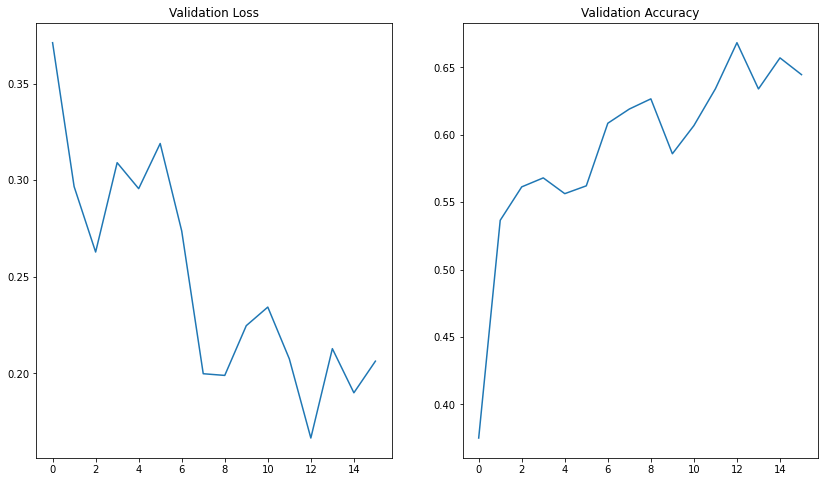

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].plot(pretrained_model.val_loss_log)
ax[0].set_title("Validation Loss")
ax[1].plot(pretrained_model.val_accuracy_log)
ax[1].set_title("Validation Accuracy")
plt.show()

Works not bad, but overfit. For further improvements: add more data and more augmentations